# 1. Imports

In [1]:
# native packages
import os, subprocess, itertools, time, logging, warnings

# some setup
warnings.filterwarnings('ignore', module='tqdm')
logger = logging.getLogger(__name__)

# other packages
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import numpy as np
from IPython.display import clear_output
from tqdm.auto import tqdm

# custom package
import sl_utils

# sklearn imports
from sklearn import svm
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import (
  KFold,
  cross_val_score,
  train_test_split,
  StratifiedKFold,
  GridSearchCV,
  RandomizedSearchCV,
  LearningCurveDisplay,
  cross_validate
)
from sklearn.metrics import (
    r2_score,
    f1_score,
    mean_squared_error,
)
from sklearn.feature_selection import (
    mutual_info_regression, 
    f_regression,
    mutual_info_classif, 
    f_classif,
    SelectKBest,
    SelectPercentile
)
from scipy.stats import pointbiserialr

# 2. Load Data from Kaggle

In [2]:
DATA = sl_utils.SL_Report_Data()
DATA.set_up_data()

Already have Cancer Dataset
Cancer Demo Saved
Already Have Bankruptcy Dataset
Bankruptcy Demo Saved


# 3. Cancer

In [3]:
# find best features?

# cancer data setup
targets = ['Treatment_Cost_USD', 'Survival_Years', 'Target_Severity_Score']
categoricals = ['Gender', 'Country_Region', 'Cancer_Type', 'Cancer_Stage']
cancer_data = DATA.get_cancer_full()
cancer_data = cancer_data.sample(cancer_data.shape[0]//3)

# drop outputs and patient IDs
cancer_inputs = pd.get_dummies(
    cancer_data.drop(['Patient_ID']+targets, axis=1),
    columns = categoricals,
    drop_first = True
    ).astype(int)

# cancer_dimred = SelectPercentile(mutual_info_regression, percentile=25)
# cancer_dimred.fit(cancer_inputs, cancer_data['Target_Severity_Score'])
# cancer_inputs_new = cancer_dimred.transform(cancer_inputs)
# cancer_inputs_new.shape, cancer_dimred.get_feature_names_out()

for col in cancer_inputs.columns:
    if sorted(cancer_inputs[col].unique().tolist()) == [0,1]:
        corr = pointbiserialr(cancer_inputs[col], cancer_data['Target_Severity_Score'])[0]
        print(col, '|', round(corr, 2))

Gender_Male | -0.01
Gender_Other | 0.01
Country_Region_Brazil | -0.01
Country_Region_Canada | 0.01
Country_Region_China | -0.0
Country_Region_Germany | 0.0
Country_Region_India | -0.0
Country_Region_Pakistan | -0.01
Country_Region_Russia | 0.0
Country_Region_UK | 0.0
Country_Region_USA | 0.0
Cancer_Type_Cervical | 0.0
Cancer_Type_Colon | -0.0
Cancer_Type_Leukemia | 0.01
Cancer_Type_Liver | -0.0
Cancer_Type_Lung | -0.0
Cancer_Type_Prostate | -0.0
Cancer_Type_Skin | -0.01
Cancer_Stage_Stage I | 0.0
Cancer_Stage_Stage II | 0.0
Cancer_Stage_Stage III | 0.0
Cancer_Stage_Stage IV | -0.0


In [8]:
1 - (0.31/cancer_data['Target_Severity_Score'].var())

np.float64(0.7829926247238647)

In [ ]:
# col = 'Target_Severity_Score'
# plt.hist(
#     cancer_data[col],
#     weights=np.ones(cancer_data.shape[0])/cancer_data.shape[0],
#     bins=70
# )
# mean = np.mean(cancer_data[col])
# std = np.std(cancer_data[col])
# sevmin, sevmax = np.min(cancer_data[col]), np.max(cancer_data[col])
# print('Mean:', mean)
# print('STD:', std)
# print('Min:', sevmin)
# print('Max:', sevmax)
# plt.vlines(mean, 0, 0.05, color='black', label='Mean')
# plt.vlines([mean-2*std, mean+2*std], 0, 0.05, color='black', linestyles='dashed', label='2 STDs')
# plt.scatter([sevmin, sevmax], [0, 0], color='black', marker='^', label='Extrema')
# plt.title(f'{" ".join(col.split("_")).title()} Distribution')
# plt.ylabel('%')
# plt.xlabel('Value')
# plt.legend()
# plt.show()

In [ ]:
# cancer_inputs.corrwith(cancer_data['Target_Severity_Score'])

In [ ]:
# for col in cancer_inputs.columns:
#     if all([word not in col for word in ['Type', 'Gender', 'Country']]):
#         plt.scatter(cancer_inputs[col], cancer_data['Target_Severity_Score'], alpha=0.5)
#         plt.title(col)
#         plt.xlabel(col)
#         plt.ylabel('Target Severity Score')
#         # plt.scatter(np.mean(cancer_inputs[col]), np.mean(cancer_data['Target_Severity_Score']), marker='.', color='black')
#         plt.show()

In [ ]:
# transformed_cancer_data = pd.DataFrame(RobustScaler().fit_transform(cancer_inputs), columns=cancer_inputs.columns)

# for col in cancer_data.columns:
#     if col in cancer_inputs.columns:
#         # distribtutions
#         plt.hist(
#             transformed_cancer_data[col], 
#             weights=np.ones(cancer_data.shape[0])/cancer_data.shape[0], 
#             color='blue', 
#             alpha=0.5, 
#             label=col
#         )
#         plt.hist(
#             cancer_data['Target_Severity_Score']-np.mean(cancer_data['Target_Severity_Score']), 
#             weights=np.ones(cancer_data.shape[0])/cancer_data.shape[0],
#             color='orange',
#             alpha=0.5,
#             label='Target Severity Score'
#         )
#         # means
#         plt.vlines(np.mean(transformed_cancer_data[col]), 0, 1, color='blue')
#         plt.vlines(0, 0, 1, color='orange')
#         # setup
#         plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
#         plt.title(f'"{col}" Distribution')
#         plt.legend()
#         plt.show()


# 4. Bankruptcy

In [3]:
# setup
bankruptcy_data = DATA.get_bankruptcy_full()
cols = bankruptcy_data.columns
bankruptcy_data = pd.DataFrame(RobustScaler().fit_transform(bankruptcy_data), columns=cols)
bankruptcy0 = bankruptcy_data[bankruptcy_data['Bankrupt?']==0]
bankruptcy1 = bankruptcy_data[bankruptcy_data['Bankrupt?']==1]
shape0 = bankruptcy0.shape[0]
shape1 = bankruptcy1.shape[0]

# # compare distributions
# for col in bankruptcy_data.columns:
#     if col != 'Bankrupt?':
#         # # distributions
#         # plt.hist(bankruptcy0[col], weights=np.ones(shape0)/shape0, alpha=0.5, color='blue', bins=50)
#         # plt.hist(bankruptcy1[col], weights=np.ones(shape1)/shape1, alpha=0.5, color='orange', bins=50)

#         # # useful stats
#         # plt.vlines(x=np.mean(bankruptcy0[col]), ymin=0, ymax=0.25, color='blue')
#         # plt.vlines(x=np.mean(bankruptcy1[col]), ymin=0, ymax=0.25, color='orange')
#         # plt.vlines(x=np.median(bankruptcy0[col]), ymin=0, ymax=0.25, color='blue', linestyles='dashed')
#         # plt.vlines(x=np.median(bankruptcy1[col]), ymin=0, ymax=0.25, color='orange', linestyles='dashed')
#         # plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
#         # plt.title(f'"{col}" Distributions')
#         # plt.legend(['Not Bankrupt', 'Bankrupt'])
#         # plt.show()
#         pass


In [11]:
correlated_with_y = []
for i, col in enumerate(bankruptcy_data.columns[1:]):
    corr = pointbiserialr(bankruptcy_data['Bankrupt?'], bankruptcy_data[col])
    if abs(corr[0]) > 0.2:  # at least moderate correlation
        print(i, '|', col[:25], '|', corr[0])
        correlated_with_y.append(col)

print(len(correlated_with_y))

bankruptcy_data[['Bankrupt?']+correlated_with_y].corr()

0 |  ROA(C) before interest a | -0.2608065575202604
1 |  ROA(A) before interest a | -0.28294058493448665
2 |  ROA(B) before interest a | -0.2730513178632929
18 |  Persistent EPS in the La | -0.2195596811907869
22 |  Per Share Net profit bef | -0.2013948344528665
36 |  Debt ratio % | 0.2501609620666181
37 |  Net worth/Assets | -0.250160962066618
42 |  Net profit before tax/Pa | -0.2078565199928763
67 |  Retained Earnings to Tot | -0.21777877998712347
85 |  Net Income to Total Asse | -0.3154569716142992
10


c:\Python312\Lib\site-packages\scipy\stats\_stats_py.py:5405: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rpb, prob = pearsonr(x, y)


,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Persistent EPS in the Last Four Seasons,Per Share Net profit before tax (Yuan ¥),Debt ratio %,Net worth/Assets,Net profit before tax/Paid-in capital,Retained Earnings to Total Assets,Net Income to Total Assets
Bankrupt?,1.000000,-0.260807,-0.282941,-0.273051,-0.219560,-0.201395,0.250161,-0.250161,-0.207857,-0.217779,-0.315457
ROA(C) before interest and depreciation before interest,-0.260807,1.000000,0.940124,0.986849,0.775006,0.750564,-0.261427,0.261427,0.753339,0.650217,0.887670
ROA(A) before interest and % after tax,-0.282941,0.940124,1.000000,0.955741,0.764828,0.752578,-0.259972,0.259972,0.758234,0.718013,0.961552
ROA(B) before interest and depreciation after tax,-0.273051,0.986849,0.955741,1.000000,0.764597,0.722940,-0.264734,0.264734,0.726003,0.673738,0.912040
Persistent EPS in the Last Four Seasons,-0.219560,0.775006,0.764828,0.764597,1.000000,0.955591,-0.177429,0.177429,0.959461,0.492078,0.691152
Per Share Net profit before tax (Yuan ¥),-0.201395,0.750564,0.752578,0.722940,0.955591,1.000000,-0.158897,0.158897,0.962723,0.473736,0.671748
Debt ratio %,0.250161,-0.261427,-0.259972,-0.264734,-0.177429,-0.158897,1.000000,-1.000000,-0.164110,-0.235423,-0.281422
Net worth/Assets,-0.250161,0.261427,0.259972,0.264734,0.177429,0.158897,-1.000000,1.000000,0.164110,0.235423,0.281422
Net profit before tax/Paid-in capital,-0.207857,0.753339,0.758234,0.726003,0.959461,0.962723,-0.164110,0.164110,1.000000,0.483355,0.683623
Retained Earnings to Total Assets,-0.217779,0.650217,0.718013,0.673738,0.492078,0.473736,-0.235423,0.235423,0.483355,1.000000,0.794189


In [ ]:
def best_feature_names(metric, X, y, percentile=25):
    dimred = SelectPercentile(metric, percentile=percentile)
    dimred.fit(X, y)
    return dimred.get_feature_names_out()

bankruptcy_best_cols = best_feature_names(mutual_info_classif, bankruptcy_data.drop('Bankrupt?', axis=1), bankruptcy_data['Bankrupt?'], percentile=10)

bankruptcy_best_cols = []
for i, col in enumerate(bankruptcy_best_cols):
    corr = pointbiserialr(bankruptcy_data['Bankrupt?'], bankruptcy_data[col])
    if abs(corr[0]) >=0.2:
        print(i, '|', col[:50], '|', round(corr[0],2))
        bankruptcy_best_cols.append(col)

bankruptcy_data[['Bankrupt?']+list(bankruptcy_best_cols)].corr()

0 |  ROA(A) before interest and % after tax | -0.28
2 |  Persistent EPS in the Last Four Seasons | -0.22
3 |  Per Share Net profit before tax (Yuan ¥) | -0.2
5 |  Debt ratio % | 0.25
7 |  Net profit before tax/Paid-in capital | -0.21
8 |  Net Income to Total Assets | -0.32


,Bankrupt?,ROA(A) before interest and % after tax,Continuous interest rate (after tax),Persistent EPS in the Last Four Seasons,Per Share Net profit before tax (Yuan ¥),Interest Expense Ratio,Debt ratio %,Borrowing dependency,Net profit before tax/Paid-in capital,Net Income to Total Assets,Net Income to Stockholder's Equity
Bankrupt?,1.000000,-0.282941,-0.008395,-0.219560,-0.201395,-0.002681,0.250161,0.176543,-0.207857,-0.315457,-0.180987
ROA(A) before interest and % after tax,-0.282941,1.000000,0.049909,0.764828,0.752578,0.005440,-0.259972,-0.161868,0.758234,0.961552,0.291744
Continuous interest rate (after tax),-0.008395,0.049909,1.000000,0.032051,0.030487,0.001479,-0.001192,-0.002887,0.030334,0.045600,0.011191
Persistent EPS in the Last Four Seasons,-0.219560,0.764828,0.032051,1.000000,0.955591,0.000007,-0.177429,-0.144138,0.959461,0.691152,0.222961
Per Share Net profit before tax (Yuan ¥),-0.201395,0.752578,0.030487,0.955591,1.000000,-0.001111,-0.158897,-0.142138,0.962723,0.671748,0.218389
Interest Expense Ratio,-0.002681,0.005440,0.001479,0.000007,-0.001111,1.000000,0.023196,0.007844,-0.001346,0.004969,0.003604
Debt ratio %,0.250161,-0.259972,-0.001192,-0.177429,-0.158897,0.023196,1.000000,0.329109,-0.164110,-0.281422,-0.123986
Borrowing dependency,0.176543,-0.161868,-0.002887,-0.144138,-0.142138,0.007844,0.329109,1.000000,-0.134924,-0.177781,-0.806478
Net profit before tax/Paid-in capital,-0.207857,0.758234,0.030334,0.959461,0.962723,-0.001346,-0.164110,-0.134924,1.000000,0.683623,0.215690
Net Income to Total Assets,-0.315457,0.961552,0.045600,0.691152,0.671748,0.004969,-0.281422,-0.177781,0.683623,1.000000,0.328492


  0%|          | 0/100 [00:00<?, ?it/s]

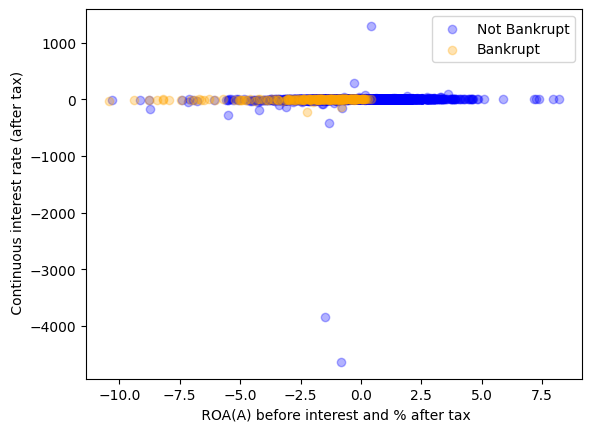

  2%|▏         | 2/100 [00:01<01:03,  1.54it/s]

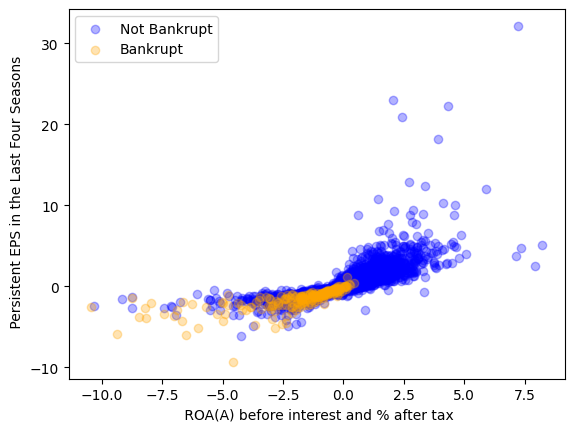

  3%|▎         | 3/100 [00:01<00:50,  1.93it/s]

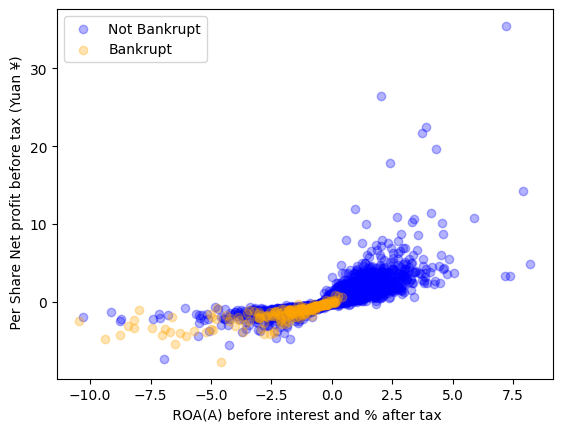

  4%|▍         | 4/100 [00:02<00:48,  1.99it/s]

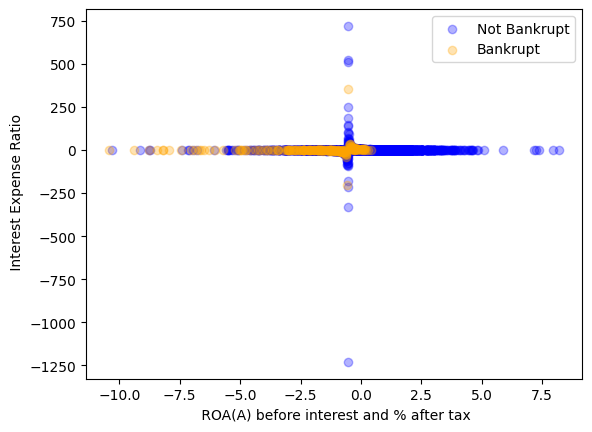

  5%|▌         | 5/100 [00:02<00:41,  2.27it/s]

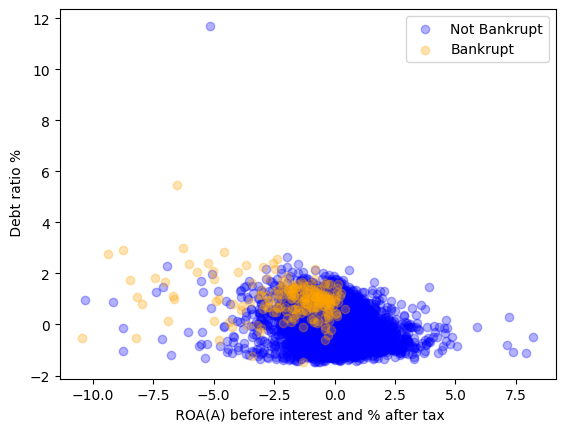

  6%|▌         | 6/100 [00:02<00:39,  2.37it/s]

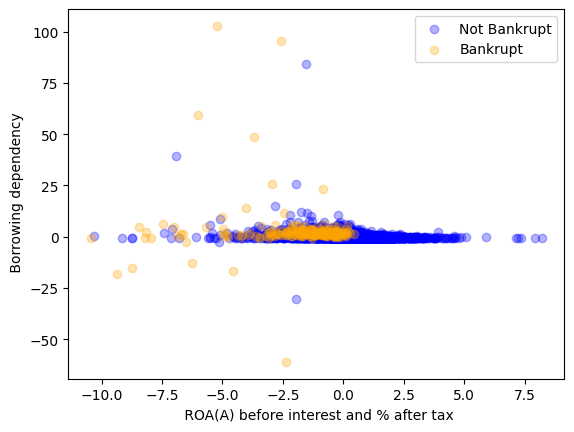

  7%|▋         | 7/100 [00:03<00:37,  2.46it/s]

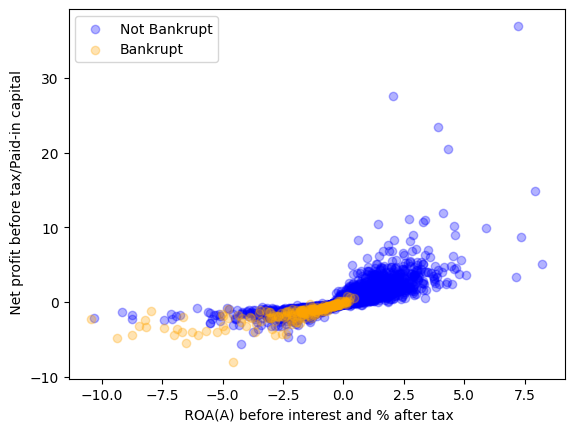

  8%|▊         | 8/100 [00:03<00:34,  2.63it/s]

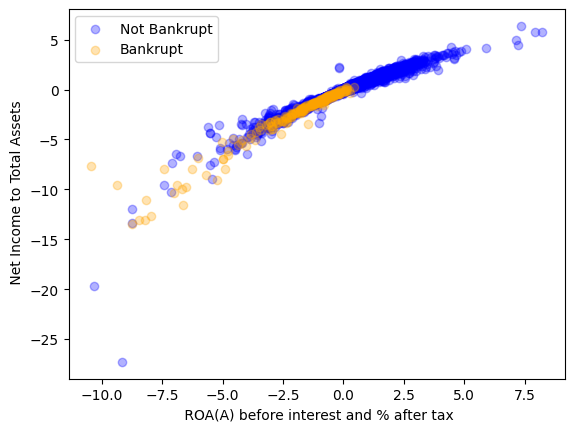

  9%|▉         | 9/100 [00:03<00:32,  2.82it/s]

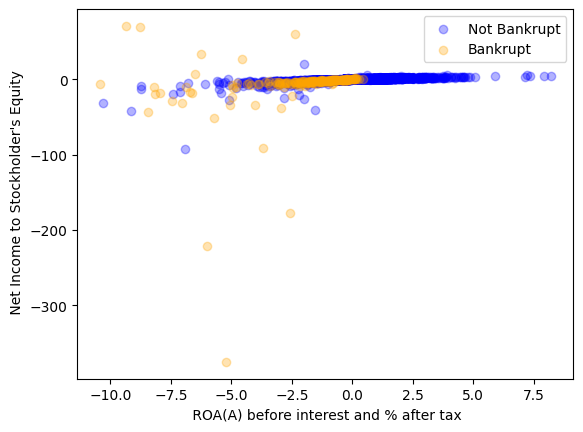

 10%|█         | 10/100 [00:04<00:31,  2.88it/s]

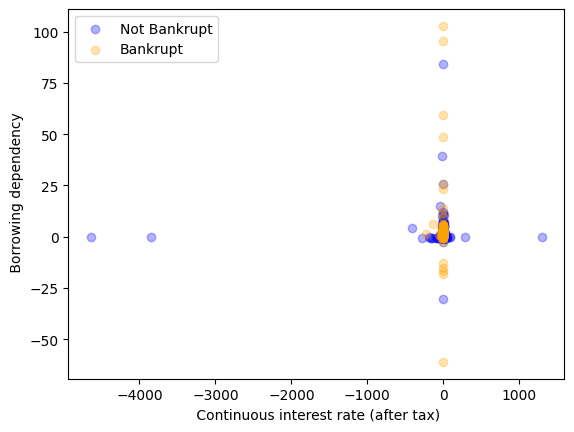

 17%|█▋        | 17/100 [00:04<00:09,  8.57it/s]

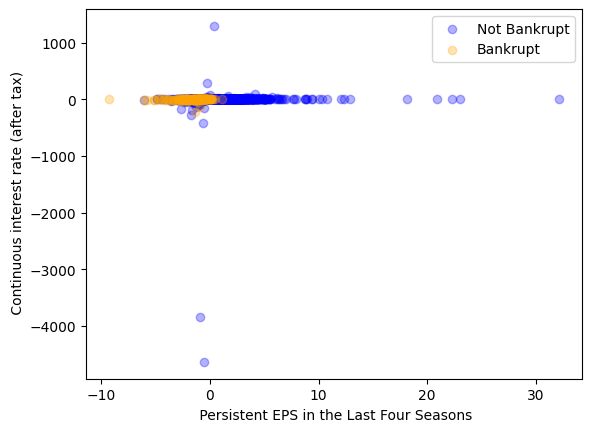

 22%|██▏       | 22/100 [00:04<00:07, 10.73it/s]

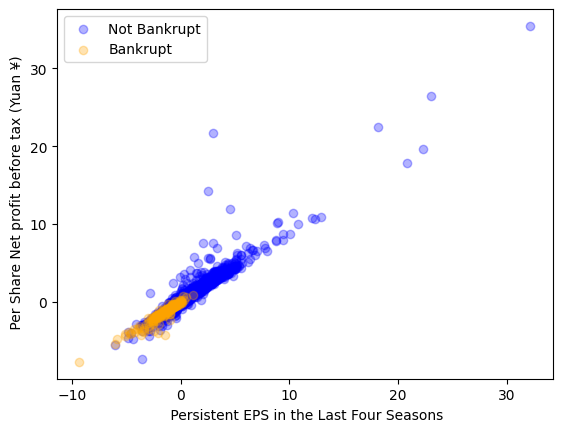

 24%|██▍       | 24/100 [00:05<00:08,  8.62it/s]

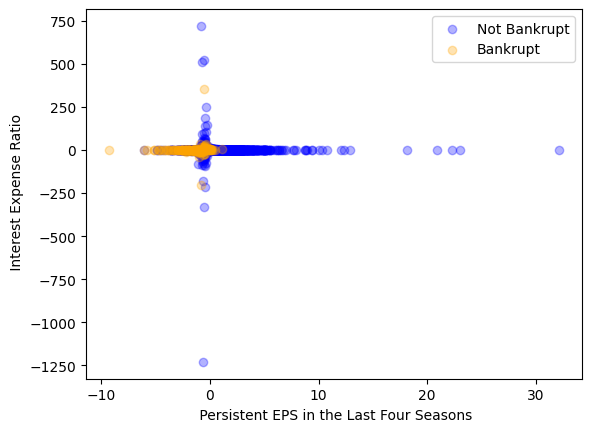

 25%|██▌       | 25/100 [00:05<00:10,  6.98it/s]

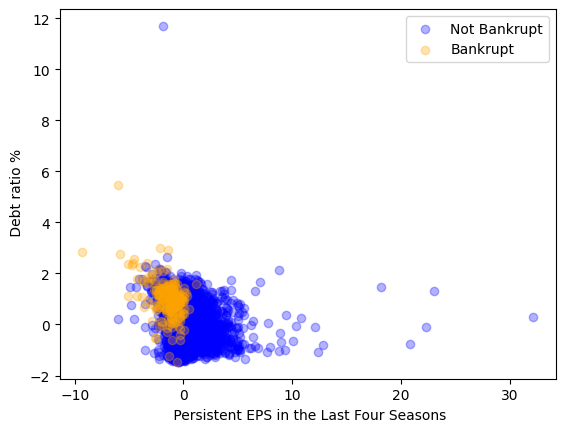

 26%|██▌       | 26/100 [00:05<00:12,  5.94it/s]

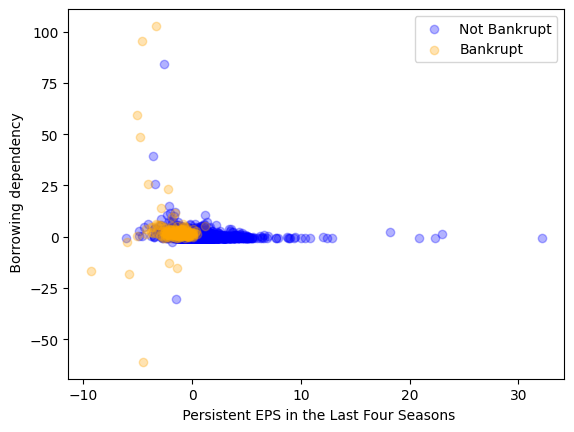

 27%|██▋       | 27/100 [00:06<00:14,  5.05it/s]

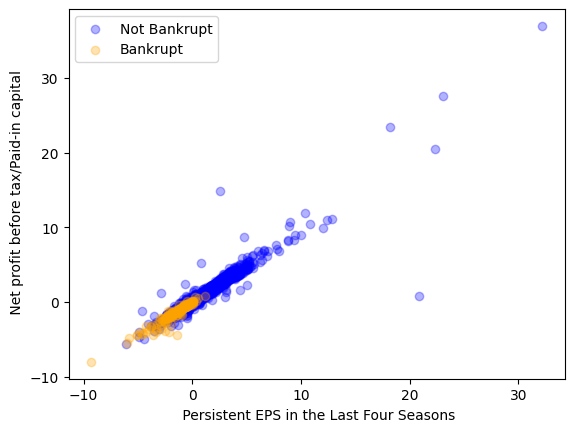

 28%|██▊       | 28/100 [00:06<00:15,  4.60it/s]

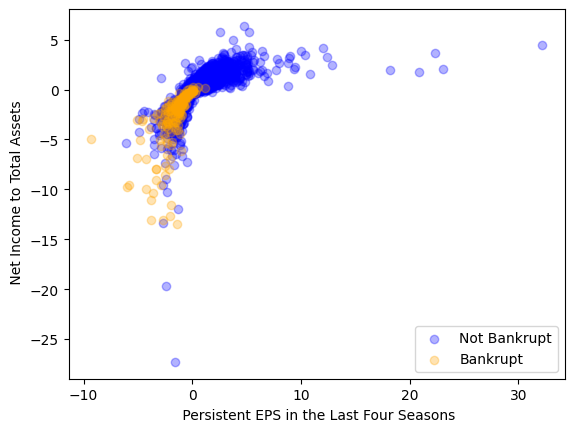

 29%|██▉       | 29/100 [00:06<00:17,  4.08it/s]

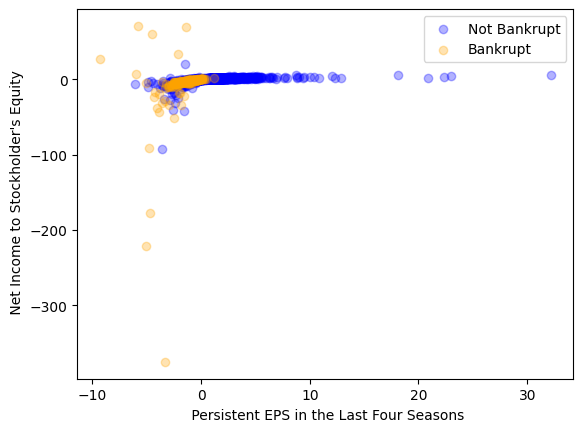

 30%|███       | 30/100 [00:07<00:17,  4.07it/s]

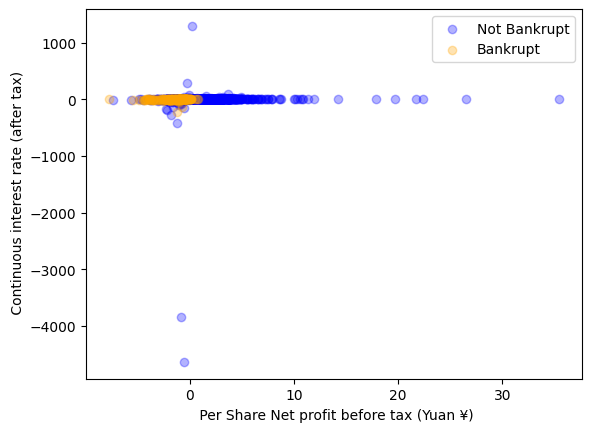

 32%|███▏      | 32/100 [00:07<00:14,  4.80it/s]

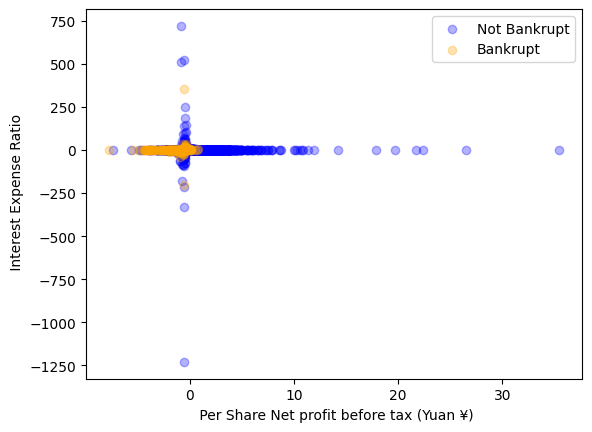

 35%|███▌      | 35/100 [00:07<00:10,  6.45it/s]

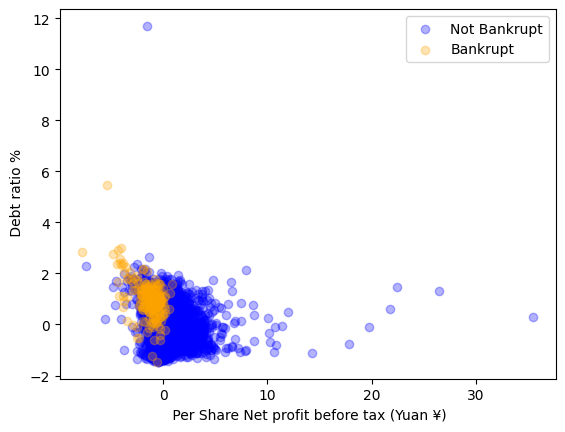

 36%|███▌      | 36/100 [00:07<00:11,  5.68it/s]

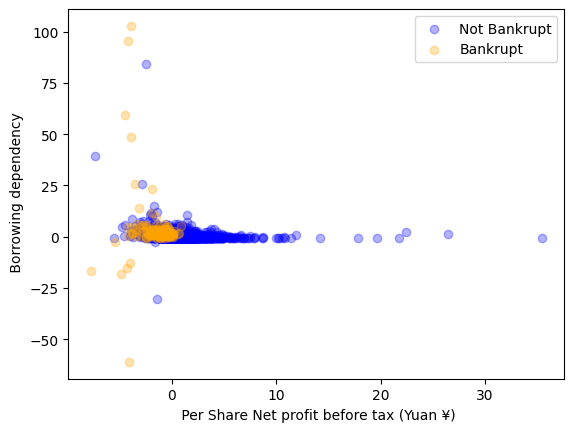

 37%|███▋      | 37/100 [00:08<00:22,  2.79it/s]

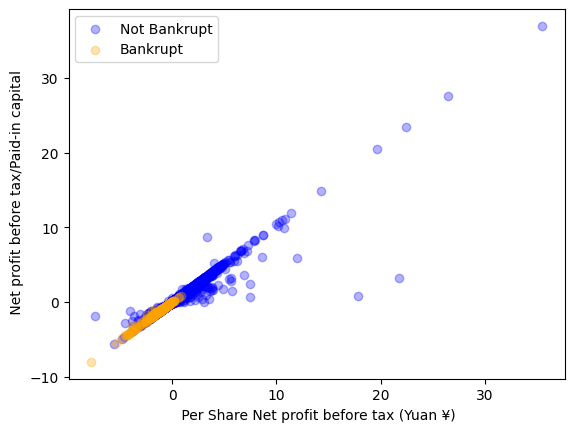

 38%|███▊      | 38/100 [00:09<00:21,  2.87it/s]

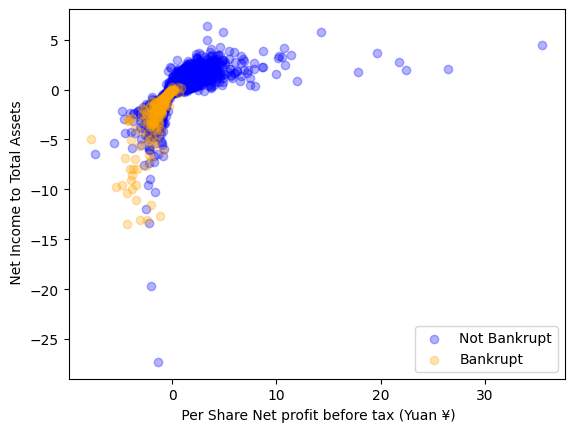

 39%|███▉      | 39/100 [00:09<00:21,  2.81it/s]

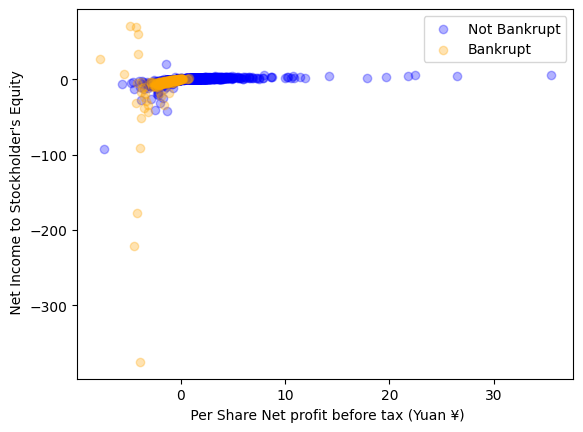

 40%|████      | 40/100 [00:10<00:21,  2.73it/s]

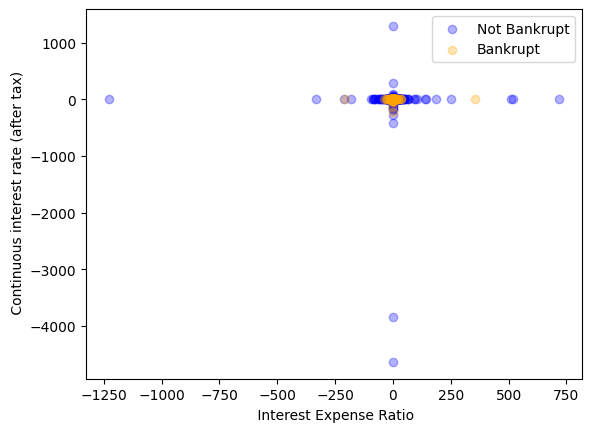

 42%|████▏     | 42/100 [00:10<00:15,  3.64it/s]

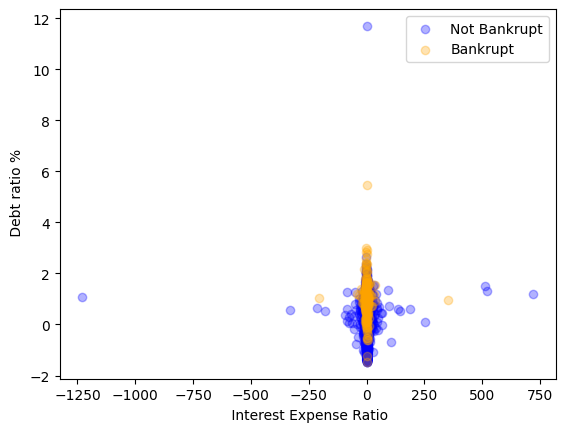

 46%|████▌     | 46/100 [00:10<00:08,  6.07it/s]

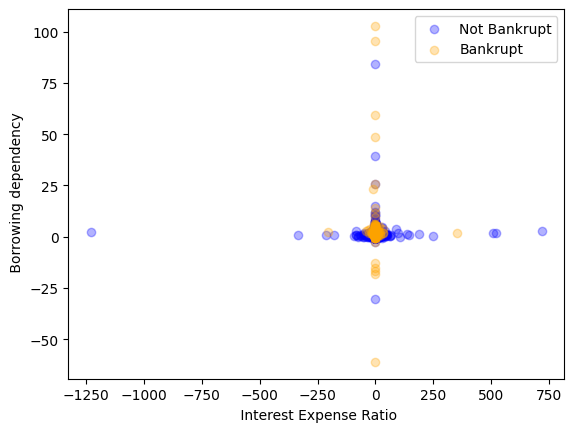

 47%|████▋     | 47/100 [00:10<00:09,  5.45it/s]

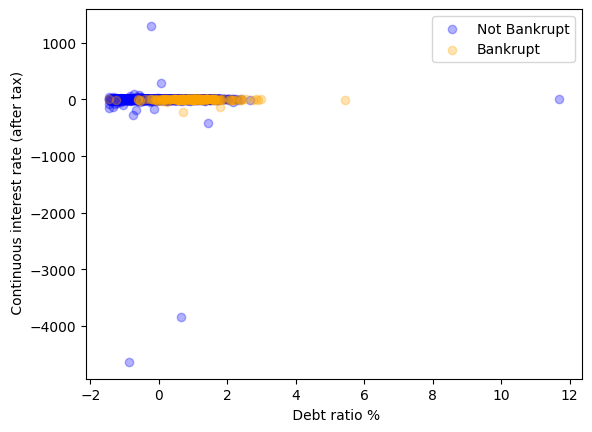

 52%|█████▏    | 52/100 [00:11<00:05,  8.64it/s]

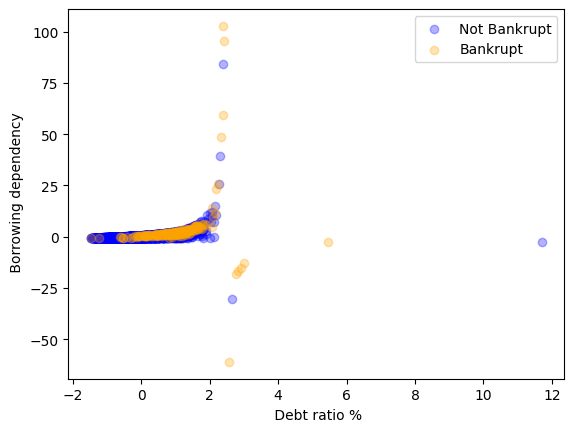

 57%|█████▋    | 57/100 [00:11<00:03, 11.07it/s]

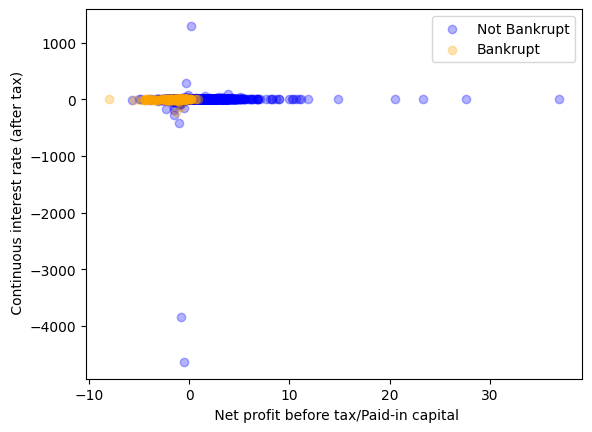

 72%|███████▏  | 72/100 [00:11<00:01, 23.00it/s]

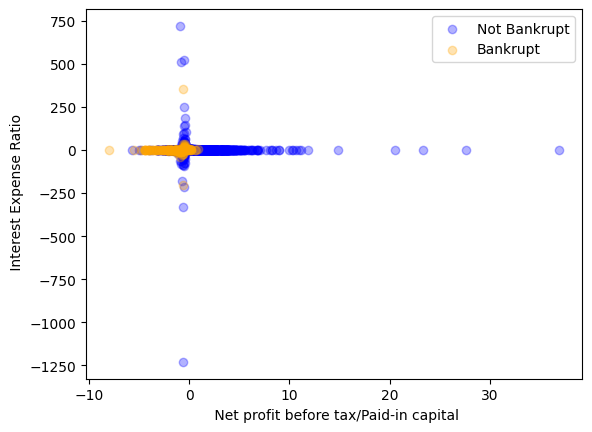

 75%|███████▌  | 75/100 [00:12<00:01, 19.18it/s]

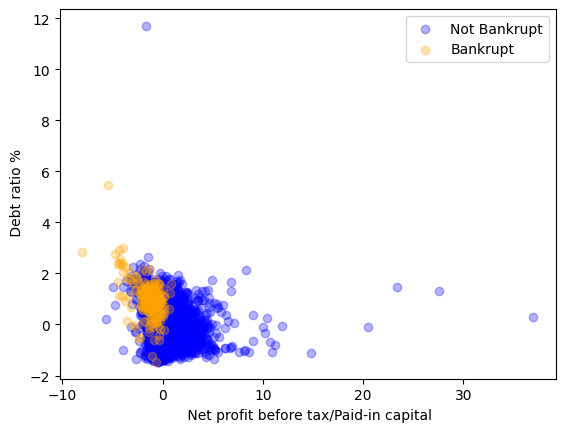

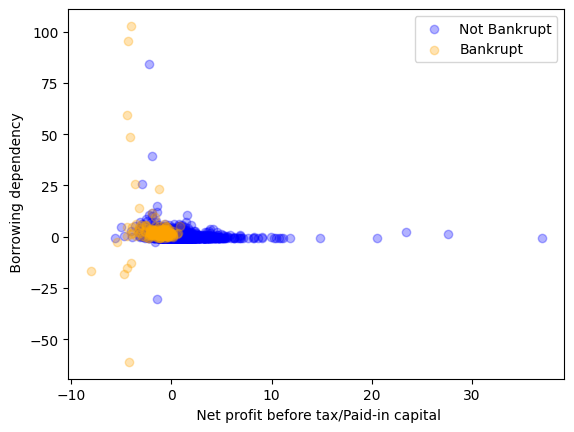

 78%|███████▊  | 78/100 [00:12<00:01, 13.16it/s]

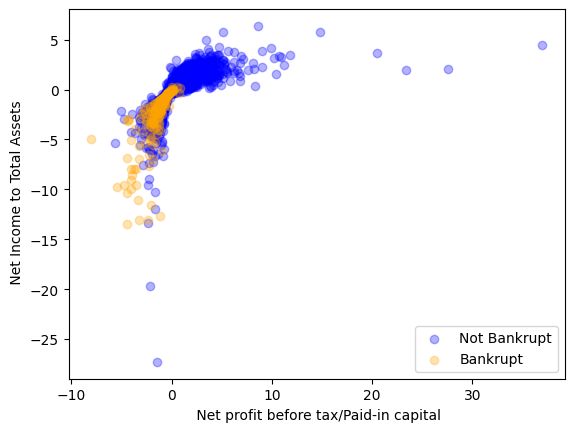

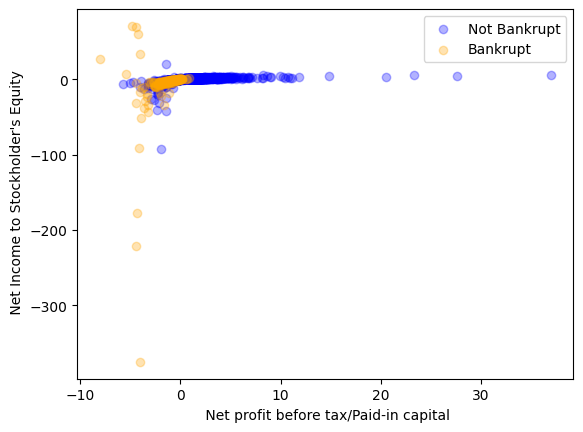

 80%|████████  | 80/100 [00:13<00:02,  8.54it/s]

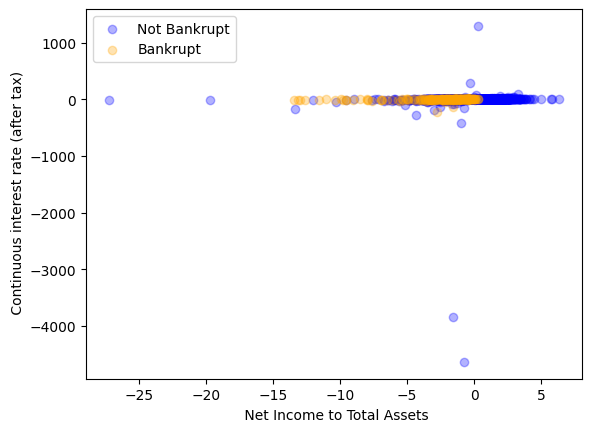

 82%|████████▏ | 82/100 [00:13<00:02,  7.98it/s]

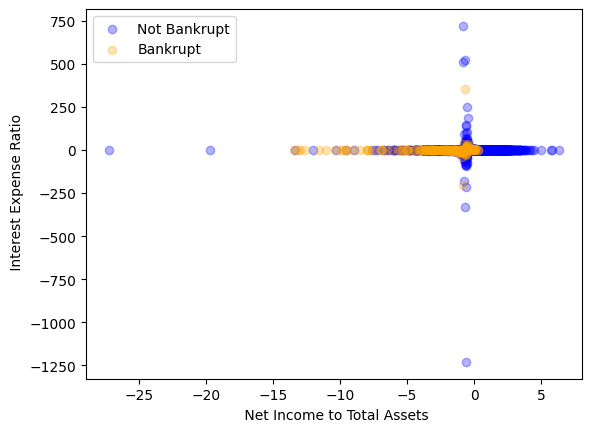

 85%|████████▌ | 85/100 [00:14<00:01,  8.06it/s]

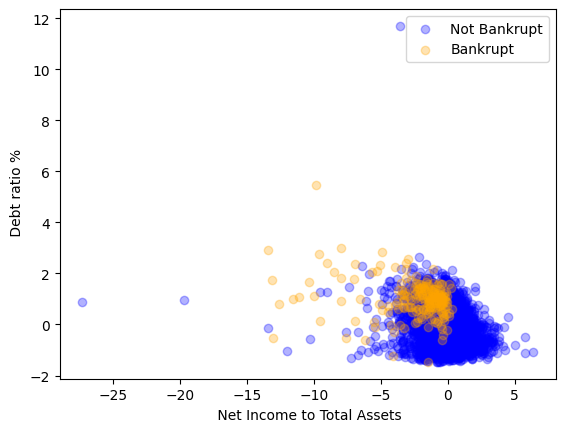

 86%|████████▌ | 86/100 [00:14<00:02,  6.86it/s]

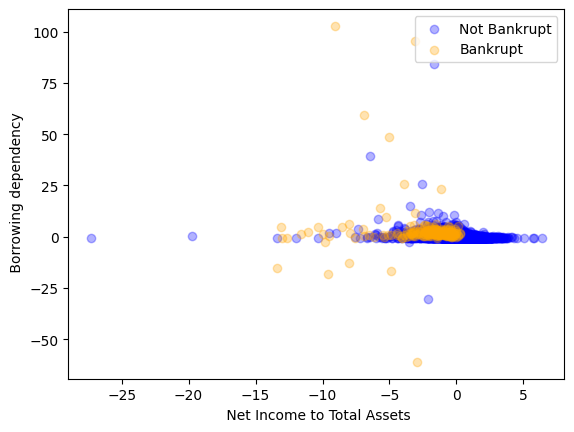

 87%|████████▋ | 87/100 [00:14<00:02,  6.14it/s]

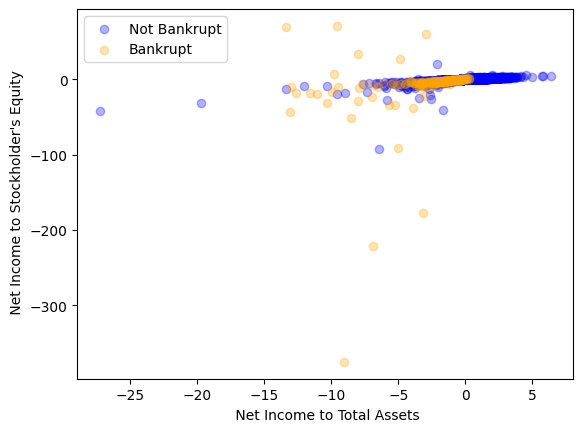

 90%|█████████ | 90/100 [00:14<00:01,  7.24it/s]

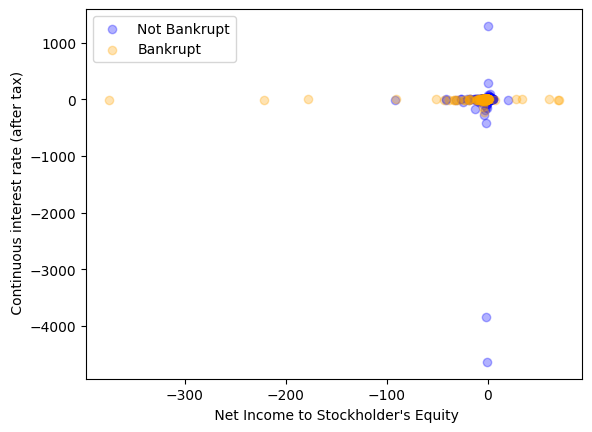

 92%|█████████▏| 92/100 [00:15<00:01,  6.16it/s]

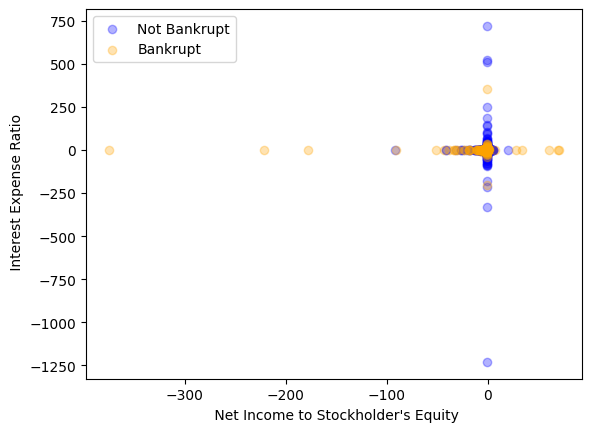

 95%|█████████▌| 95/100 [00:15<00:00,  6.88it/s]

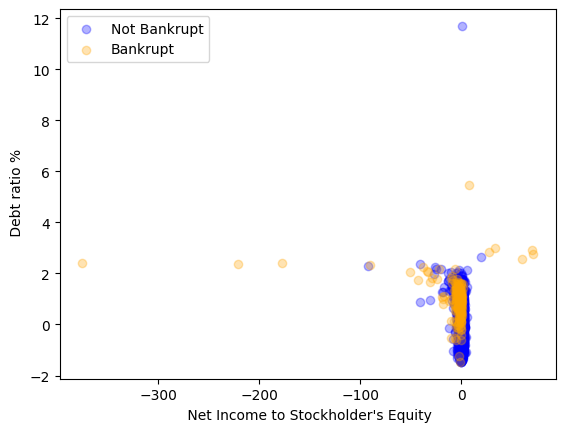

 96%|█████████▌| 96/100 [00:15<00:00,  5.91it/s]

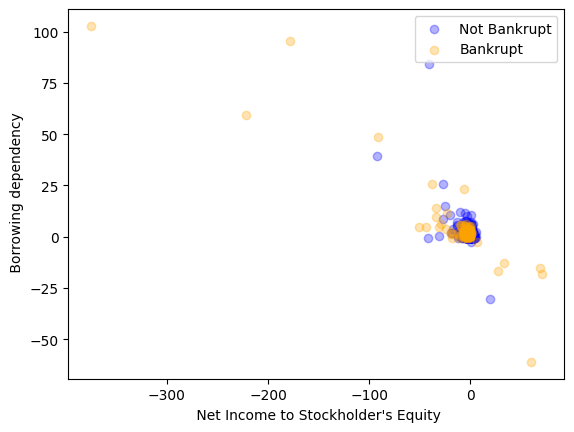

100%|██████████| 100/100 [00:16<00:00,  6.15it/s]


In [10]:
noteworthy_col_pairs = []
for icol, jcol in tqdm(itertools.product(bankruptcy_best_cols, bankruptcy_best_cols), total=len(bankruptcy_best_cols)**2):
        if icol != 'Bankrupt?' and jcol != 'Bankrupt?' and icol>jcol:
            centroids = [
                np.array((np.median(bankruptcy0[icol]), np.median(bankruptcy0[jcol]))), 
                np.array((np.median(bankruptcy1[icol]), np.median(bankruptcy1[jcol])))
                ]
            centroid_distance = np.linalg.norm(centroids[0] - centroids[1])
            variances = np.var(pd.concat([bankruptcy_data[[icol, jcol]]]), axis=0).values  # variance by column
            reasonable_centroid_distance = np.sqrt(sum([v**2 for v in variances]))  # betting on our boy Pythagoras
            # if centroid_distance >= reasonable_centroid_distance:
                # noteworthy_col_pairs.append((icol, jcol))
            plt.scatter(bankruptcy0[icol], bankruptcy0[jcol], color='blue', label='Not Bankrupt', alpha=0.3)
            plt.scatter(bankruptcy1[icol], bankruptcy1[jcol], color='orange', label='Bankrupt', alpha=0.3)
                # plt.scatter(*centroids[0], color='black', label='Not Bankrupt Centroid', marker='^')
                # plt.scatter(*centroids[1], color='black', label='Bankrupt Centroid', marker='v')
                # plt.plot(
                #     [c[0] for c in centroids], 
                #     [c[1] for c in centroids], 
                #     color='black', 
                #     label=f'Distance: {round(centroid_distance, 2)}')
                # plt.title(f'Assumed Reasonable Centroid Distance: {round(reasonable_centroid_distance, 2)}')
            plt.legend()
            plt.xlabel(icol)
            plt.ylabel(jcol)
            plt.show()

            pass

for icol, jcol in noteworthy_col_pairs:
    b0mult = bankruptcy0[icol]*bankruptcy0[jcol]
    b1mult = bankruptcy1[icol]*bankruptcy1[jcol]
    plt.scatter(b0mult, np.zeros((bankruptcy0.shape[0],)), color='blue', label='Not Bankrupt')
    plt.scatter(b1mult, np.ones((bankruptcy1.shape[0],)), color='orange', label='Bankrupt')
    plt.vlines(np.median(b0mult), 0, 1, color='blue')
    plt.vlines(np.median(b1mult), 0, 1, color='orange')
    plt.title(f'"{icol}" x \n"{jcol}"')
    plt.xlabel('Multiplied Value')
    plt.ylabel('Bankrupt?')
    plt.legend()
    plt.show()
